In [488]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import Aer
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_bloch_multivector
from qiskit.circuit.library import HamiltonianGate, RYGate, UnitaryGate
from qiskit.quantum_info import SparsePauliOp
from qiskit.quantum_info import Pauli, partial_trace
from qiskit.visualization import plot_bloch_vector
import matplotlib.pyplot as plt
from math import pi, ceil
import scipy

## QFT

In [489]:
def process_qbit(qc: QuantumCircuit, qbit: int):
    
    qc.h(qbit)

    for i in range(1, qc.num_qubits - qbit):
        qc.cp(np.pi / (2 ** i), qbit + i, qbit)
    
    return qc

def swap_registers(circuit: QuantumCircuit):
    for qubit in range(circuit.num_qubits // 2):
        circuit.swap(qubit, circuit.num_qubits - qubit - 1)
    return circuit


def qft(qc: QuantumCircuit):

    swap_registers(qc)

    for i in range(qc.num_qubits):
        process_qbit(qc, i)

    
    return qc




### QFT example

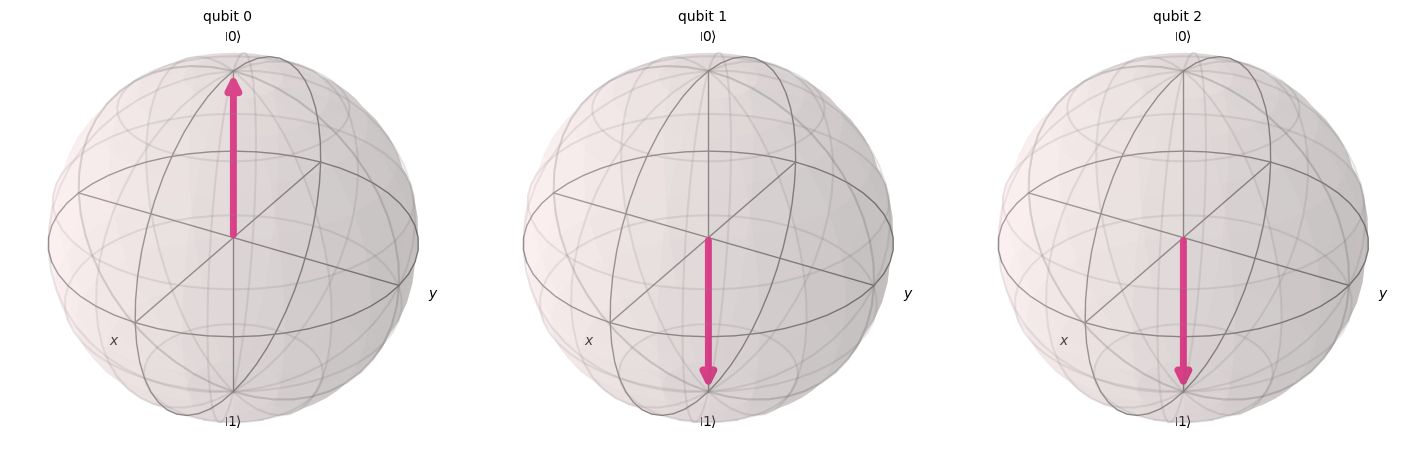

In [490]:
qc = QuantumCircuit(3)

qc.x(2)
qc.x(1)
qc.draw()

sim = Aer.get_backend("aer_simulator")
qc_init = qc.copy()
qc_init.save_statevector()
statevector = sim.run(qc_init).result().get_statevector()
plot_bloch_multivector(statevector)

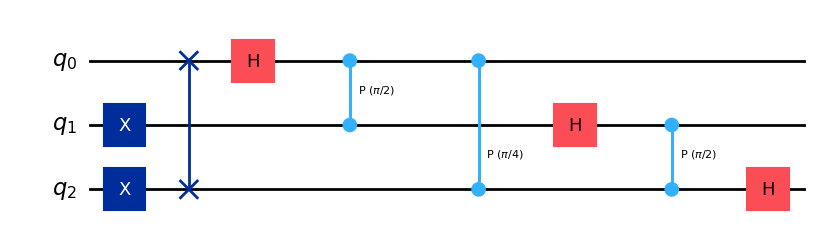

In [491]:

qft(qc)
qc.draw('mpl')

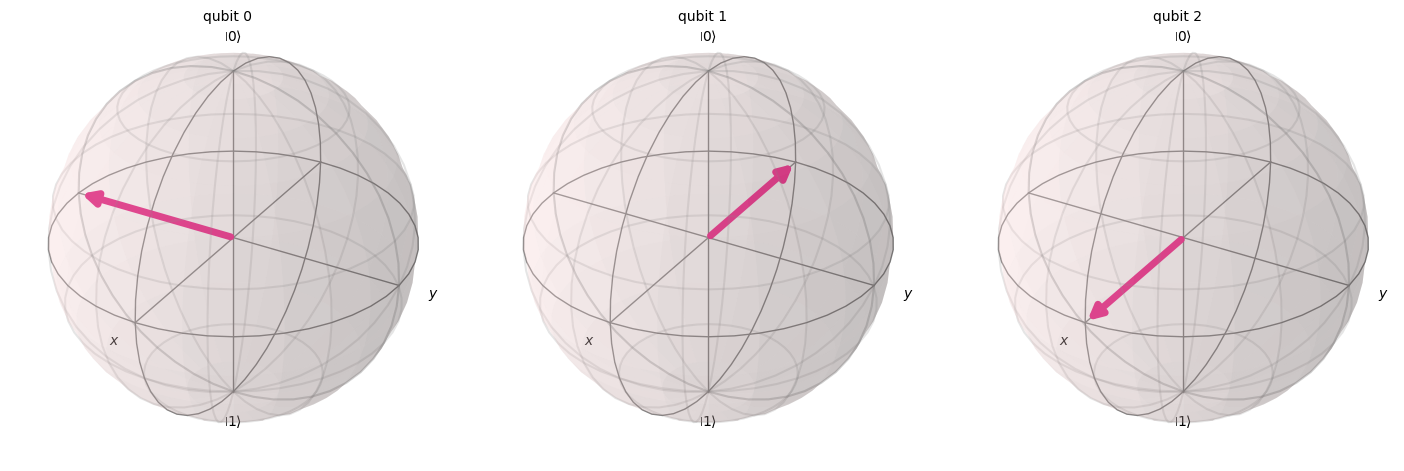

In [492]:
qc.save_statevector()
statevector = sim.run(qc).result().get_statevector()
plot_bloch_multivector(statevector)

## IQFT

### We use build in inverse function. Take adjoint of the gate. Recursively inverting all gates.

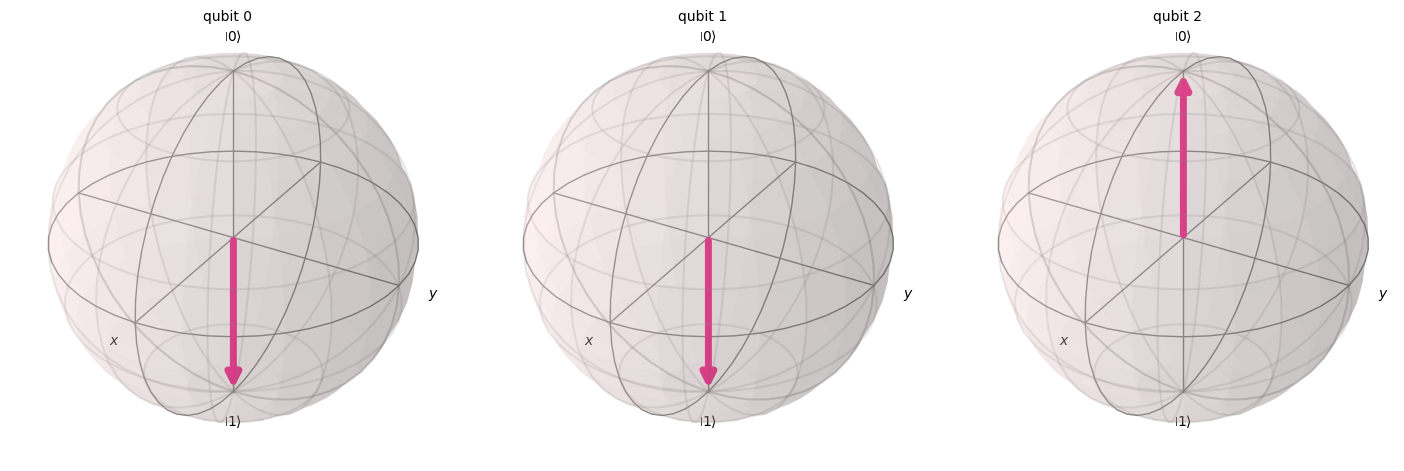

In [493]:
qc = QuantumCircuit(3)


qc.x(0)
qc.x(1)

statevector = Statevector.from_instruction(qc)
plot_bloch_multivector(statevector)

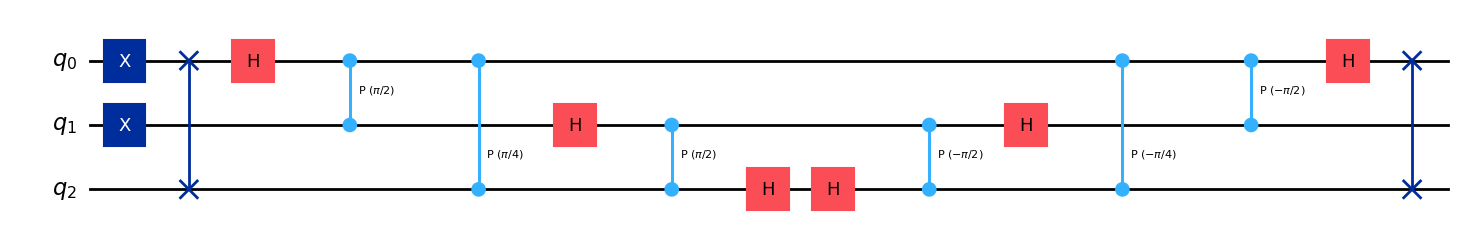

In [494]:
qtf_qc = QuantumCircuit(3)
qft(qtf_qc)

inv = qtf_qc.inverse()
qtf_qc.compose(inv, inplace=True)
qc.compose(qtf_qc, inplace=True)

qc.draw('mpl')


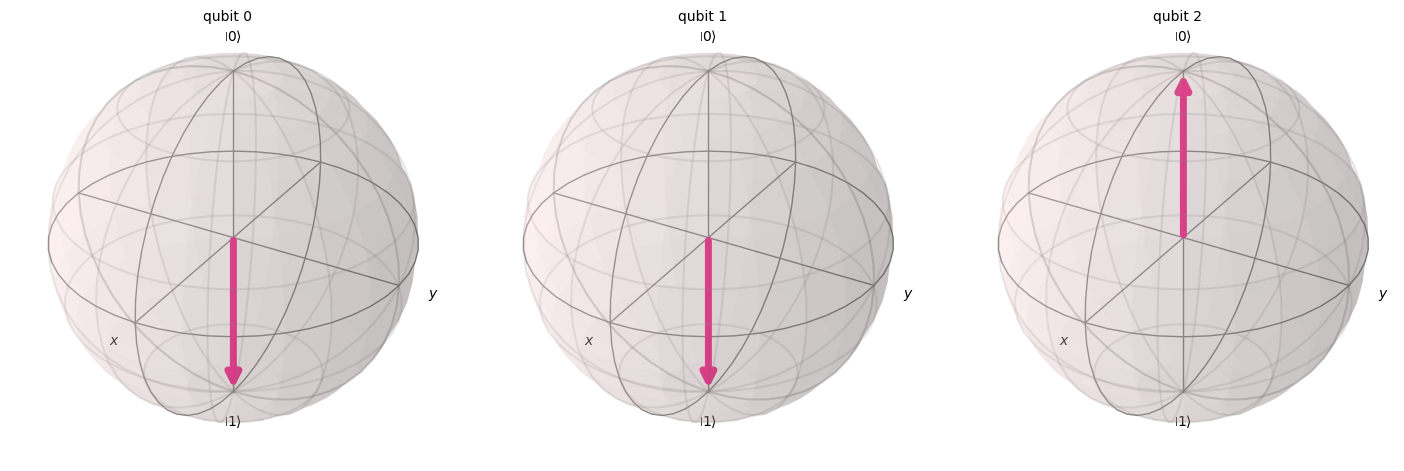

In [495]:
qc.save_statevector()
statevector = sim.run(qc).result().get_statevector()
plot_bloch_multivector(statevector)


State preparation

In [496]:
def prepare(qc: QuantumCircuit, b: np.array):
    b_normalized = b / np.linalg.norm(b)
    qc.initialize(b_normalized, qc.qubits)

In [497]:
def plot_qubit_states(statevector, title):
    num_qubits = statevector.num_qubits
    fig = plt.figure(figsize=(num_qubits * 3, 3))
    for qubit in range(num_qubits):
        rho = partial_trace(statevector, [q for q in range(num_qubits) if q != qubit])
        x = rho.expectation_value(Pauli("X")).real
        y = rho.expectation_value(Pauli("Y")).real
        z = rho.expectation_value(Pauli("Z")).real
        ax = fig.add_subplot(1, num_qubits, qubit + 1, projection="3d")
        plot_bloch_vector([x, y, z], title=f"Qubit {qubit}", ax=ax)
    plt.suptitle(title)
    plt.show()

### Showcasing setting state of b-reg

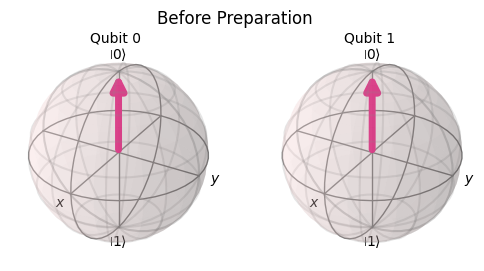

In [498]:
b_reg = QuantumRegister(2, "b")
qc = QuantumCircuit(b_reg)

plot_qubit_states(Statevector.from_instruction(qc), "Before Preparation")

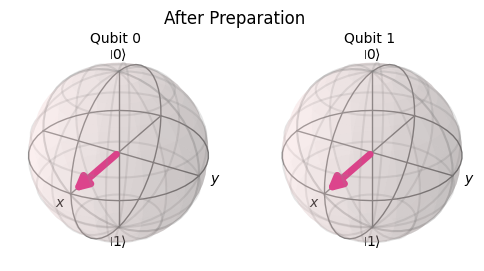

In [499]:

b = np.array([0.5, 0.5, 0.5, 0.5])
prepare(qc, b)

final_state = Statevector(qc)

plot_qubit_states(final_state, "After Preparation")

plt.show()

/Users/vitya/Documents/la/LA_HHL_project/.env/lib/python3.12/site-packages/qiskit/visualization/circuit/matplotlib.py:269: UserWarning: Style JSON file 'iqx.json' not found in any of these locations: /Users/vitya/Documents/la/LA_HHL_project/.env/lib/python3.12/site-packages/qiskit/visualization/circuit/styles/iqx.json, iqx.json. Will use default style.
  self._style, def_font_ratio = load_style(self._style)


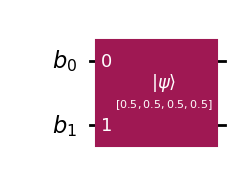

In [500]:
qc.draw("mpl", style="iqx")

Hadamart Gate

In [501]:
def hadamart(qc: QuantumCircuit, qbit: int):
    qc.h(qbit)

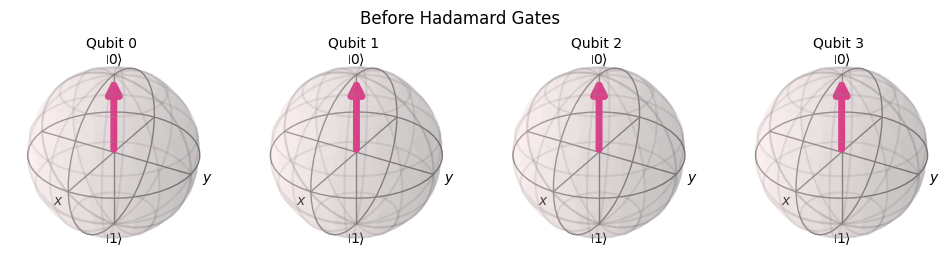

In [502]:
n_qubits = 3
c_reg = QuantumRegister(n_qubits, "c")
b_reg = QuantumRegister(1, "b")
qc = QuantumCircuit(c_reg, b_reg)

initial_state = Statevector.from_instruction(qc)

plot_qubit_states(initial_state, "Before Hadamard Gates")

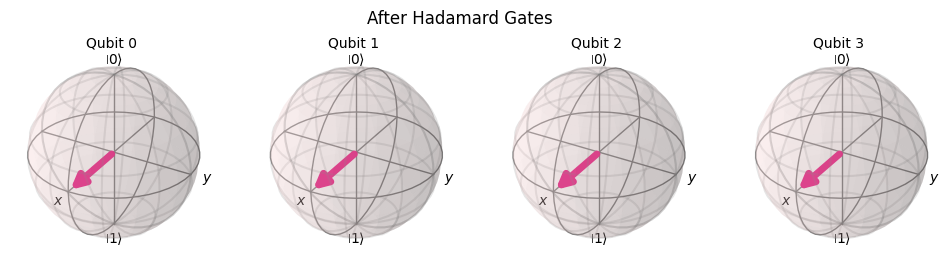

In [503]:

for i in range(4):
    hadamart(qc, i)

final_state = Statevector(qc)

plot_qubit_states(final_state, "After Hadamard Gates")


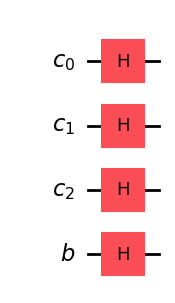

In [504]:
qc.draw("mpl", style="iqx")

Controlled Hamiltonian-gate

In [505]:
def eiAt(circuit, c_reg, b_reg, A, t):

    num_controls = len(c_reg)

    for k in range(num_controls):

        scaled_time = (2**k) * t

        h_gate = HamiltonianGate(-A, scaled_time) # add explanation for impl
        controlled_h = h_gate.control(1)

        circuit.append(controlled_h, [c_reg[k]] + list(b_reg))


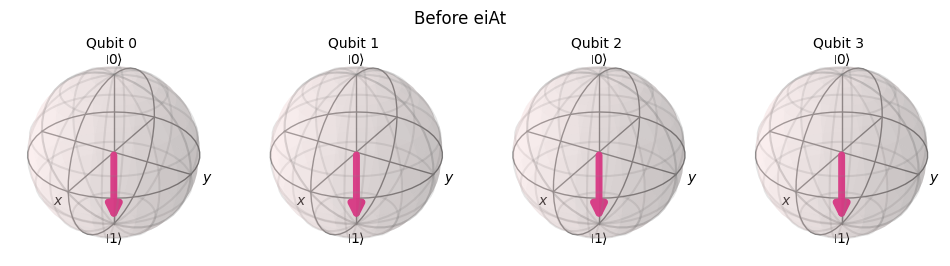

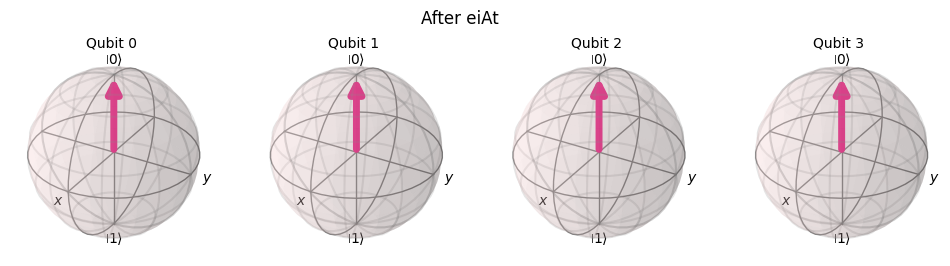

In [506]:
n_qubits = 3
t = 0.1

c_reg = QuantumRegister(n_qubits, "c")
b_reg = QuantumRegister(1, "b")
qc = QuantumCircuit(c_reg, b_reg)

A = SparsePauliOp("Z")

initial_state = Statevector.from_label("1" * qc.num_qubits)

eiAt(qc, c_reg, b_reg, A, t)

final_state = Statevector(qc)

plot_qubit_states(initial_state, "Before eiAt")
plot_qubit_states(final_state, "After eiAt")

qc.draw("mpl", style="iqx")
plt.show()

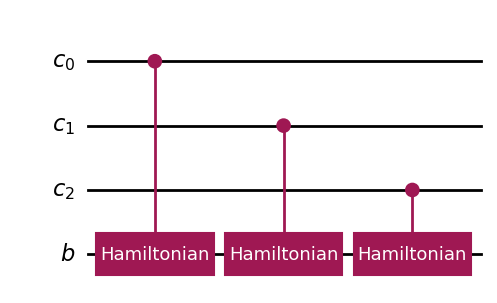

In [507]:
qc.draw("mpl", style="iqx")

Reversed controlled Hamiltonian-gate

In [508]:
def reverse_eiAt(circuit, c_reg, b_reg, A, t):
    num_controls = len(c_reg)

    for k in reversed(range(num_controls)):
        scaled_time = (2**k) * t

        h_gate = HamiltonianGate(A, scaled_time) 
        controlled_h = h_gate.control(1)

        circuit.append(controlled_h, [c_reg[k]] + list(b_reg))

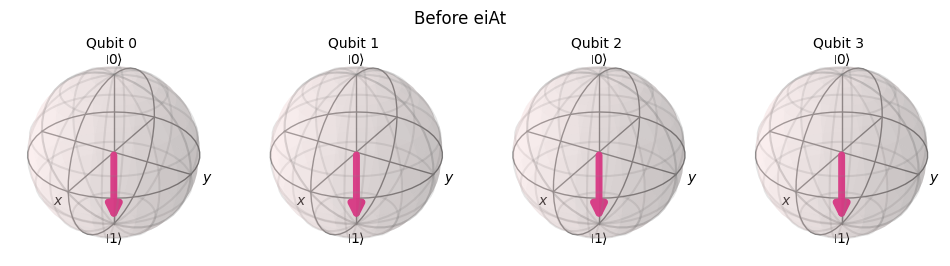

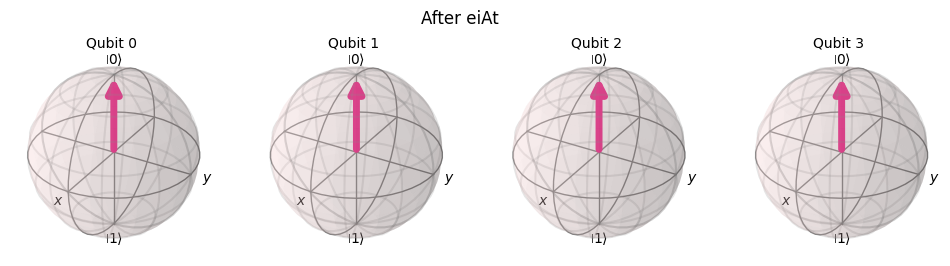

In [509]:
n_qubits = 3
t = 0.1

c_reg = QuantumRegister(n_qubits, "c")
b_reg = QuantumRegister(1, "b")
qc = QuantumCircuit(c_reg, b_reg)

A = SparsePauliOp("Z")

initial_state = Statevector.from_label("1" * qc.num_qubits)

reverse_eiAt(qc, c_reg, b_reg, A, t)

final_state = Statevector(qc)

plot_qubit_states(initial_state, "Before eiAt")
plot_qubit_states(final_state, "After eiAt")

qc.draw("mpl", style="iqx")
plt.show()

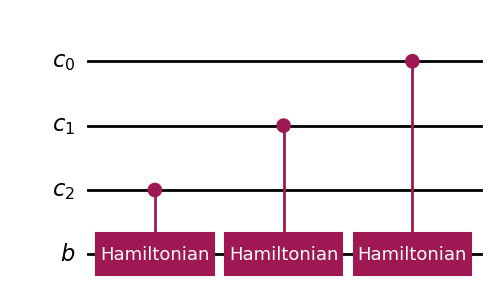

In [510]:
qc.draw("mpl", style="iqx")

Implementation

In [511]:
def prepare_register(qc: QuantumCircuit, b: np.array, target_reg: QuantumRegister):
    b_normalized = b / np.linalg.norm(b)
    qc.initialize(b_normalized, target_reg)

def eiAt(circuit, c_reg, b_reg, A, t):

    num_controls = len(c_reg)

    for k in range(num_controls):

        scaled_time = (2**k) * t

        h_gate = HamiltonianGate(-A, scaled_time)

        controlled_h = h_gate.control(1)
        circuit.append(controlled_h, [c_reg[k]] + list(b_reg))
    
    return circuit

def reverse_eiAt(circuit, c_reg, b_reg, A, t):
    num_controls = len(c_reg)

    for k in reversed(range(num_controls)):
        scaled_time = (2**k) * t

        h_gate = HamiltonianGate(A, scaled_time) 

        controlled_h = h_gate.control(1)

        circuit.append(controlled_h, [c_reg[k]] + list(b_reg))


A = np.array([[1, -1/3], [-1/3, 1]])
b = np.array([0, 1])

def estimate_c_reg_size(A):
    eigvals = np.linalg.eigvals(A)
    min_eigh = min(abs(eigvals))
    norm_eigh = eigvals / min_eigh

    n_c = ceil(max(norm_eigh)).bit_length()
    return n_c, norm_eigh

def add_controlled_rotations(circuit, c_req, a_reg, eigvals, C):
    num_c = len(c_req)

    for eigenval in eigvals:

        binary_repr = format(ceil(eigenval), f"0{num_c}b")

        control_qubits = [c_req[num_c - i - 1] for i, bit in enumerate(binary_repr) if bit == "1"]

        rotation = RYGate(2 * np.arcsin(C / eigenval)).control(len(control_qubits))

        circuit.append(rotation, control_qubits + [a_reg[0]])


def HHL(A, b, draw_qc = False):
    n_c, norm_eigh = estimate_c_reg_size(A)
    n_b = ceil(np.log2(len(b)))

    t = 3 * pi / 4

    c_reg = QuantumRegister(n_c, "c")
    b_reg = QuantumRegister(n_b, "b")
    a_reg = QuantumRegister(1, "a")
    clas = ClassicalRegister(2, "classical")

    qc = QuantumCircuit(a_reg, c_reg, b_reg, clas)

    prepare_register(qc, b, b_reg)

    qc.barrier()

    for qubit in c_reg:
        qc.h(qubit)

    qc.barrier()

    eiAt(qc, c_reg, b_reg, A, t)

    qc.barrier()

    qft_circuit = QuantumCircuit(c_reg)
    qft(qft_circuit)
    inverse_qft = qft_circuit.inverse()
    qc.compose(inverse_qft, qubits=c_reg, inplace=True)

    qc.barrier()
    
    add_controlled_rotations(qc, c_reg, a_reg, norm_eigh, 1)

    qc.barrier()

    qc.compose(qft_circuit, qubits=c_reg, inplace=True)

    qc.barrier()

    reverse_eiAt(qc, c_reg, b_reg, A, t)

    qc.barrier()

    for qubit in c_reg:
        qc.h(qubit)

    qc.barrier()

    curr_state = Statevector(qc)

    probabilities = curr_state.probabilities_dict()
    
    if (draw_qc):
        qc.draw("mpl")

    return curr_state, probabilities

    
qc_state, probabilities = HHL(A,b)
print("Probabilities of each state:")
for state, prob in probabilities.items():
    print(f"{state}: {prob}")

print(probabilities['0001'] / probabilities['1001'])

Probabilities of each state:
0000: 0.1874999999999997
0001: 0.062499999999999944
0010: 3.0099753053322074e-33
0011: 9.77200669813935e-33
0100: 7.108377482744171e-33
0101: 5.065231158496997e-33
0110: 7.348255682000358e-34
0111: 3.439943529874215e-33
1000: 0.18749999999999964
1001: 0.5624999999999993
1010: 1.298020106444941e-32
1011: 4.013107777826762e-33
1100: 3.867587351854066e-32
1101: 8.770989298505878e-33
1110: 3.735737331390679e-33
1111: 1.064701197594757e-32
0.11111111111111115
